In [1]:
import os
import pandas as pd
import numpy as np
import re

import time
from tqdm import tqdm
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns", 500)

# Loading data from json and creating DataFrame

In [2]:
def read_data(file = 'json_file_location.json'):
    """
    Function to load single json files
    """
    
    data_frame = pd.read_json(file, 
                               orient='records', 
                               lines=True, 
                               convert_dates=True, 
                               keep_default_dates=True)
    return data_frame

In [3]:
def load_data(file_list):
    """
    Function that loads json files from a list of files, using the read_data function,
    and appends the resulting pandas DataFrames to each other
    """
    
    df = pd.DataFrame()
    
    for file in tqdm(file_list):
        sub_df = read_data(file)
        if df.empty:
            df = sub_df
        else:
            df = df.append(sub_df)
            
    return df

In [4]:
files_list_AFD = ["../Data/AfD/AfD_2018-08-04.json", 
                  "../Data/AfD/AfD_2018-08-03.json", 
                  "../Data/AfD/AfD_2018-08-02.json", 
                  "../Data/AfD/AfD_2018-08-01.json", 
                  "../Data/AfD/AfD_2018-07-31.json", 
                  "../Data/AfD/AfD_2018-07-30.json", 
                  "../Data/AfD/AfD_2018-07-29.json"
                 ]
df_AFD = load_data(files_list_AFD)

100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


In [5]:
files_list_SPD = ["../Data/SPD/SPD_2018-08-04.json", 
                  "../Data/SPD/SPD_2018-08-03.json", 
                  "../Data/SPD/SPD_2018-08-02.json", 
                  "../Data/SPD/SPD_2018-08-01.json", 
                  "../Data/SPD/SPD_2018-07-31.json", 
                  "../Data/SPD/SPD_2018-07-30.json", 
                  "../Data/SPD/SPD_2018-07-29.json"
                 ]
df_SPD = load_data(files_list_SPD)

100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


In [6]:
# df_all_AFD.head()
# df_all_AFD.info()
# df_all_AFD.describe()

# Creating a clean dataframe that only contains relevant columns and no duplicates

In [7]:
def cleaning(df):
    """
    Creates a dataframe with distinct columns only and only german tweets; 
    defines a datetime index and sorts in an ascending manner; 
    also, deletes duplicates in the text column
    """
    
    
    ger_df = df.loc[:, ['created_at', 'id_str', 'text']][df.lang == 'de']
    ger_df = ger_df.set_index(pd.DatetimeIndex(ger_df['created_at'], inplace=True)).sort_values('created_at', ascending=True)
    
    clean_ger_df = ger_df.drop_duplicates('text')

    assert len(clean_ger_df) == (len(ger_df) - ger_df.duplicated('text').sum())
    
    return ger_df

In [8]:
clean_df_AFD = cleaning(df_AFD)

In [9]:
clean_df_SPD = cleaning(df_SPD)

# Quick excursion: Time series of tweets per minute

In [10]:
def plot_timeseries(df):
    tweetcount_df = df.loc[:, 'text'].resample('min').count()
    
    tweetcount_df.plot(figsize=(30, 7.5), color='b')
    print('hurray, first plot')

hurray, first plot


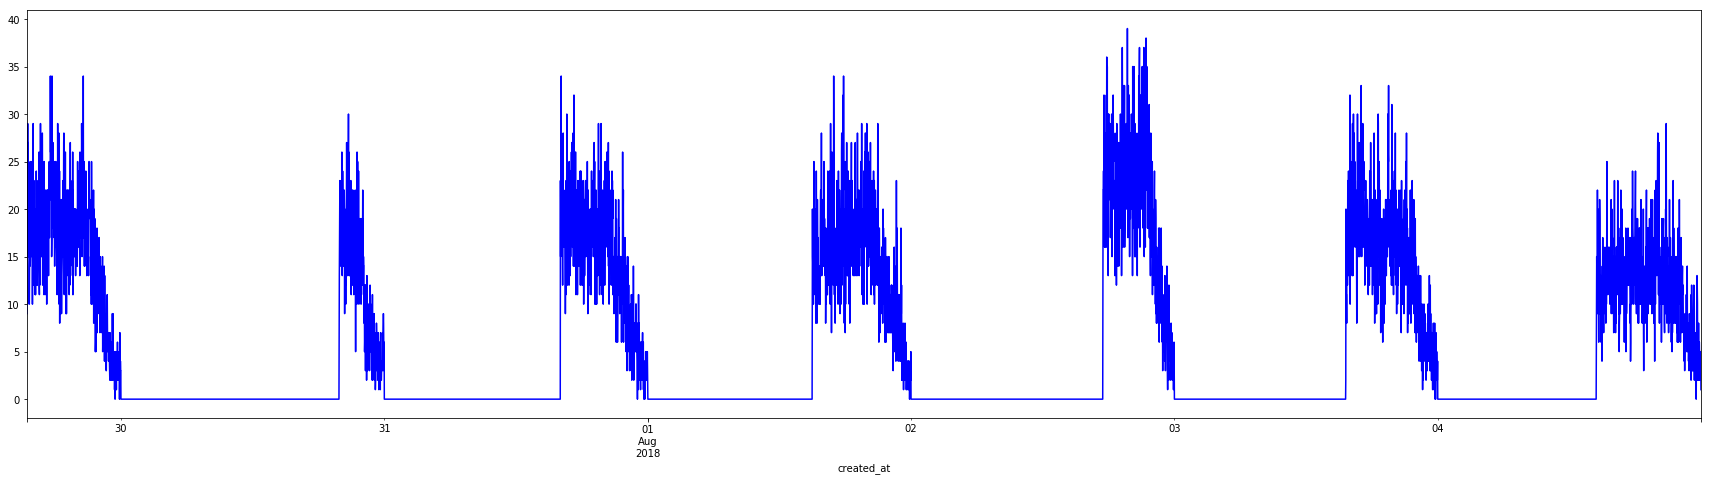

In [15]:
plot_timeseries(clean_df_AFD)
plt.show()

hurray, first plot


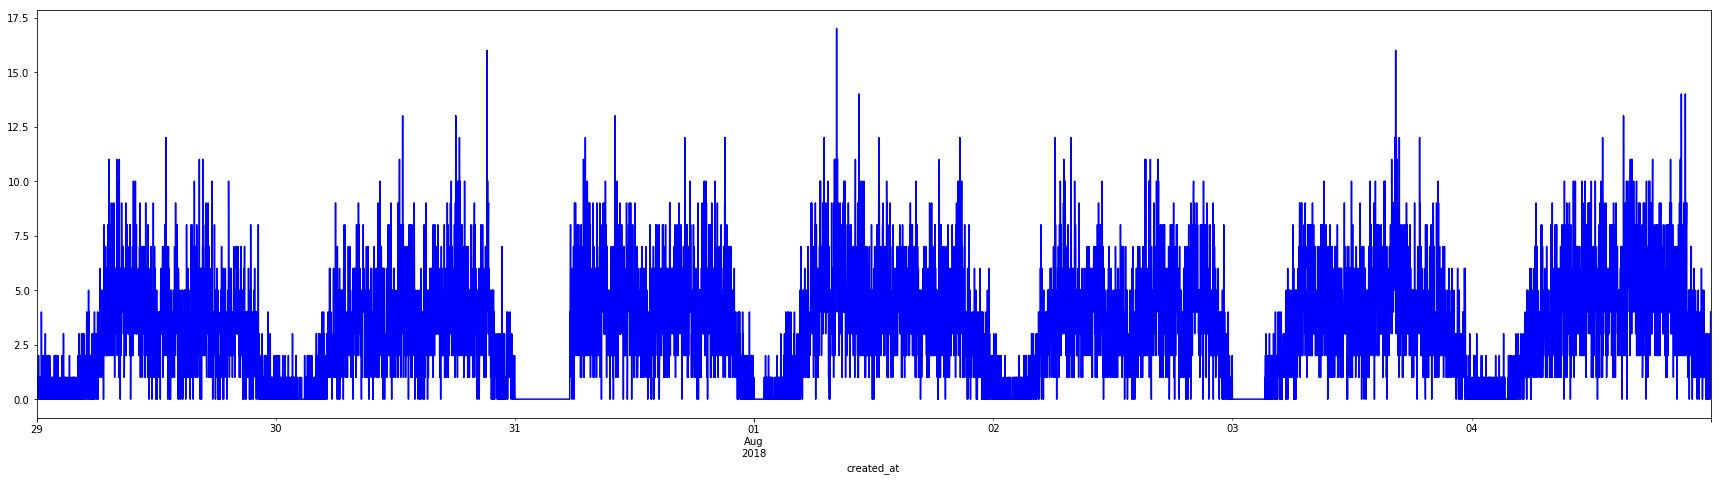

In [11]:
plot_timeseries(clean_df_SPD)
plt.show()

1. zero Tweets? 
2. Consistent with other parties?
3. Could do a Tweet count per day. 

# Feature extraction and first clustering - 'quick and dirty'

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

In [13]:
vectorizer  = CountVectorizer()
text = (clean_df_AFD.loc[:, 'text']).tolist()
X = vectorizer.fit_transform(text)

In [14]:
# did not find the afternoon-concentration to finish

# Extract hashtags and party mentions

In [15]:
text_cleaner = lambda x: " ".join(re.findall(r"[A-Za-z0-9üäöÜÄÖß#@ ]*", x))    

In [16]:
clean_df_AFD['clean_text'] = clean_df_AFD['text'].apply(text_cleaner)

clean_df_AFD.info()
clean_df_AFD['clean_text'].astype('str')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46999 entries, 2018-07-29 15:26:38 to 2018-08-04 23:59:42
Data columns (total 4 columns):
created_at    46999 non-null datetime64[ns]
id_str        46999 non-null int64
text          46999 non-null object
clean_text    46999 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.0+ MB


created_at
2018-07-29 15:26:38                                                                                              @Joerg  Meuthen @tagesschau @AfD  Fraktion  HH die haben ja auch einen knall 
2018-07-29 15:26:40                       @Vyacheslav777   @AfD @realDonaldTrump das kommt auch alles OHNE das jetzige Part  Eien System   Die AfD gehört voll m   https    t  co  kqJ6mtxhAe 
2018-07-29 15:26:41                     RT @KokoLores20   Eine   Insiderin    von der zuvor noch nie jemand etwas gehört hat   packt aus      Gähn    Totaaaal glaubwürdig      Die Propagan  
2018-07-29 15:26:41                           RT @Eckleben   Aus d spanischen Exklave #CEUTA hört man von den #illegalen #afrika  nischen Eindringlingen    Eroberern immer wieder den Ausru  
2018-07-29 15:26:43                        RT @MalteKaufmann   Na endlich   Im #Sonntagstrend von #Emnid fallen #CDU #CSU erstmals seit   06 auf 29    Die pol   Hasardeure #Merkel   #Seeho  
2018-07-29 15:26:45               

In [26]:
tag_finder = lambda x: re.findall(r"#(\w+)", x)
tag_remover = lambda x: re.sub("#(\w+)", '', x)

In [38]:
clean_df_AFD['tags'] = clean_df_AFD['text'].apply(tag_finder)
clean_df_AFD['clean_text'] = clean_df_AFD['text'].apply(text_cleaner).apply(tag_remover)

In [39]:
clean_df_AFD.head(5) #e.g. afrikanischen - look at this again!

,created_at,id_str,text,clean_text,tags,parties
created_at,,,,,,
2018-07-29 15:26:38,2018-07-29 15:26:38,1023590632684748800,@Joerg_Meuthen @tagesschau @AfD_Fraktion_HH die haben ja auch einen knall,@Joerg Meuthen @tagesschau @AfD Fraktion HH die haben ja auch einen knall,[],[AfD]
2018-07-29 15:26:40,2018-07-29 15:26:40,1023590639714414592,@Vyacheslav777_ @AfD @realDonaldTrump das kommt auch alles OHNE das jetzige Part-Eien System! Die AfD gehört voll m… https://t.co/kqJ6mtxhAe,@Vyacheslav777 @AfD @realDonaldTrump das kommt auch alles OHNE das jetzige Part Eien System Die AfD gehört voll m https t co kqJ6mtxhAe,[],"[AfD, AfD]"
2018-07-29 15:26:41,2018-07-29 15:26:41,1023590643627696128,"RT @KokoLores20: Eine ""Insiderin"", von der zuvor noch nie jemand etwas gehört hat, packt aus. \n*Gähn*. Totaaaal glaubwürdig. 🤡\nDie Propagan…",RT @KokoLores20 Eine Insiderin von der zuvor noch nie jemand etwas gehört hat packt aus Gähn Totaaaal glaubwürdig Die Propagan,[],[]
2018-07-29 15:26:41,2018-07-29 15:26:41,1023590642663006208,RT @Eckleben: Aus d spanischen Exklave #CEUTA hört man von den #illegalen #afrika|nischen Eindringlingen + Eroberern immer wieder den Ausru…,RT @Eckleben Aus d spanischen Exklave hört man von den nischen Eindringlingen Eroberern immer wieder den Ausru,"[CEUTA, illegalen, afrika]",[]
2018-07-29 15:26:43,2018-07-29 15:26:43,1023590651710136320,"RT @MalteKaufmann: Na endlich! Im #Sonntagstrend von #Emnid fallen #CDU #CSU erstmals seit '06 auf 29%. Die pol. Hasardeure #Merkel, #Seeho…",RT @MalteKaufmann Na endlich Im von fallen erstmals seit 06 auf 29 Die pol Hasardeure,"[Sonntagstrend, Emnid, CDU, CSU, Merkel, Seeho]",[]


In [43]:
parties = ['CDU', 'CSU', 'afd', 'SPD', 'Grüne', 'Linke', 'FDP', 'Gruene'] 
            
party_finder = lambda x: re.findall((parties[2]), x, re.IGNORECASE) # does not yet work as planned

In [44]:
clean_df_AFD['parties'] = clean_df_AFD['clean_text'].apply(party_finder)

In [45]:
clean_df_AFD.head(5)

,created_at,id_str,text,clean_text,tags,parties
created_at,,,,,,
2018-07-29 15:26:38,2018-07-29 15:26:38,1023590632684748800,@Joerg_Meuthen @tagesschau @AfD_Fraktion_HH die haben ja auch einen knall,@Joerg Meuthen @tagesschau @AfD Fraktion HH die haben ja auch einen knall,[],[AfD]
2018-07-29 15:26:40,2018-07-29 15:26:40,1023590639714414592,@Vyacheslav777_ @AfD @realDonaldTrump das kommt auch alles OHNE das jetzige Part-Eien System! Die AfD gehört voll m… https://t.co/kqJ6mtxhAe,@Vyacheslav777 @AfD @realDonaldTrump das kommt auch alles OHNE das jetzige Part Eien System Die AfD gehört voll m https t co kqJ6mtxhAe,[],"[AfD, AfD]"
2018-07-29 15:26:41,2018-07-29 15:26:41,1023590643627696128,"RT @KokoLores20: Eine ""Insiderin"", von der zuvor noch nie jemand etwas gehört hat, packt aus. \n*Gähn*. Totaaaal glaubwürdig. 🤡\nDie Propagan…",RT @KokoLores20 Eine Insiderin von der zuvor noch nie jemand etwas gehört hat packt aus Gähn Totaaaal glaubwürdig Die Propagan,[],[]
2018-07-29 15:26:41,2018-07-29 15:26:41,1023590642663006208,RT @Eckleben: Aus d spanischen Exklave #CEUTA hört man von den #illegalen #afrika|nischen Eindringlingen + Eroberern immer wieder den Ausru…,RT @Eckleben Aus d spanischen Exklave hört man von den nischen Eindringlingen Eroberern immer wieder den Ausru,"[CEUTA, illegalen, afrika]",[]
2018-07-29 15:26:43,2018-07-29 15:26:43,1023590651710136320,"RT @MalteKaufmann: Na endlich! Im #Sonntagstrend von #Emnid fallen #CDU #CSU erstmals seit '06 auf 29%. Die pol. Hasardeure #Merkel, #Seeho…",RT @MalteKaufmann Na endlich Im von fallen erstmals seit 06 auf 29 Die pol Hasardeure,"[Sonntagstrend, Emnid, CDU, CSU, Merkel, Seeho]",[]
